In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pwd

/content


In [1]:
import os
os.chdir('/content/drive/MyDrive/Sentiment_Analysis_Test')

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
from transformers import TFBertModel

import warnings
warnings.simplefilter('ignore')

In [4]:
df = pd.read_csv('dataset/clean_test_data.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,ID,Month,Product,Text,Polarity,Sentiment,Rating
0,1771,1771,677419,2017 / 04,HUMIDIFICATION-PHARMACY,tried several large room humidifiers find smal...,Neutral,Average,3
1,23643,23643,1201847,2022 / 02,HUMIDIFICATION-PHARMACY,give star mainly target actual item since get ...,Negative,Not Recommended,1
2,5718,5718,673665,2018 / 04,HUMIDIFICATION-PHARMACY,lightweight small foot print easy fill operate...,Positive,Excellent,5
3,24910,24910,1220606,2022 / 05,HUMIDIFICATION-PHARMACY,best year use bedroom every night heating season,Positive,Excellent,5
4,8834,8834,669181,2019 / 02,HUMIDIFICATION-PHARMACY,personal vaporizer easy clean also heat fast o...,Positive,Excellent,5


In [15]:
data = df[['Text', 'Rating']]
data.head()

,Text,Rating
0,tried several large room humidifiers find smal...,3
1,give star mainly target actual item since get ...,1
2,lightweight small foot print easy fill operate...,5
3,best year use bedroom every night heating season,5
4,personal vaporizer easy clean also heat fast o...,5


In [16]:
data

,Text,Rating
0,tried several large room humidifiers find smal...,3
1,give star mainly target actual item since get ...,1
2,lightweight small foot print easy fill operate...,5
3,best year use bedroom every night heating season,5
4,personal vaporizer easy clean also heat fast o...,5
...,...,...
2667,winter run heater often dry son skin give stuf...,5
2668,top portion position face latch keep come caus...,1
2669,feel mislead box come coupon vapopads didnt sa...,1
2670,amaze vaporizer small power allow smell take e...,5


In [17]:
data['Rating'] = data['Rating'] - 1

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [20]:
token = tokenizer.encode_plus(
    data['Text'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

In [21]:
X_input_ids = np.zeros((len(data), 256))
X_attn_masks = np.zeros((len(data), 256))

In [22]:
def generate_test_data(data, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(data['Text'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [23]:
X_input_ids, X_attn_masks = generate_test_data(data, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [24]:
labels = np.zeros((len(data), 5))
labels.shape

(2672, 5)

In [25]:
labels[np.arange(len(data)), data['Rating'].values] = 1 # one-hot encoded target tensor

In [26]:
labels

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [27]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [28]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [29]:
dataset = dataset.map(SentimentDatasetMapFunction) # converting to required format for tensorflow dataset

In [30]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [31]:
p = 1.0
test_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 100% of that for test.

In [32]:
test = dataset.take(test_size)

In [33]:
def prepare_data(input_text, tokenizer):
  token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
  return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=['Not Recommended', 'Below Average', 'Average', 'Good', 'Excellent']):
  probs = model.predict(processed_data)[0]
  return classes[np.argmax(probs)]

In [34]:
#inference
sentiment_model = tf.keras.models.load_model('/content/drive/MyDrive/Sentiment_Analysis_Test/model/5_sentiment_BERT_Clean_Subdataset_1_2_3.hdf5')

#tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
input_text = df["Text"][2]
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(sentiment_model, processed_data=processed_data)
print(f"Predicted Sentiment: {result}")

1/1 [==============================] - 4s 4s/step
Predicted Sentiment: Excellent


In [36]:
Preds = sentiment_model.predict(test)

167/167 [==============================] - 49s 263ms/step


In [38]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = sentiment_model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = tf.argmax(correct_labels,axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 319ms/step


In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(predicted_labels,correct_labels)
cm_df = pd.DataFrame(cm,columns = ['Not Recommended', 'Below Average', 'Average', 'Good', 'Excellent'],index = ['Not Recommended', 'Below Average', 'Average', 'Good', 'Excellent'])

In [41]:
cm_df

,Not Recommended,Below Average,Average,Good,Excellent
Not Recommended,383,60,24,5,24
Below Average,58,14,11,5,2
Average,116,75,79,53,81
Good,26,23,36,98,185
Excellent,45,16,25,134,1094


In [42]:
from sklearn.metrics import classification_report
print(classification_report(correct_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.77      0.61      0.68       628
           1       0.16      0.07      0.10       188
           2       0.20      0.45      0.27       175
           3       0.27      0.33      0.30       295
           4       0.83      0.79      0.81      1386

    accuracy                           0.62      2672
   macro avg       0.44      0.45      0.43      2672
weighted avg       0.67      0.62      0.64      2672



<AxesSubplot:>

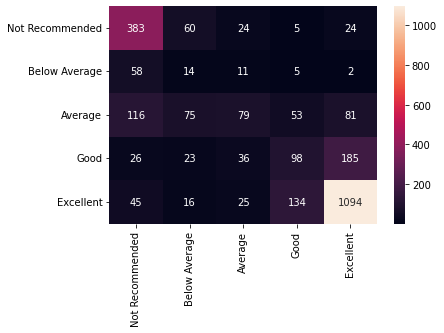

In [43]:
import seaborn as sns
sns.heatmap(cm_df,annot=True,fmt='g')